In [1]:
%pylab inline
# next 2 lines allow to automatically reload modules that have been changed externally
%reload_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(0, '/nobackup/jakravit/smartg-dev/smartg/')
from luts.luts import LUT, MLUT, Idx, merge, read_mlut

from smartg.albedo import Albedo_spectrum, Albedo_speclib, Albedo_cst
from smartg.bandset import BandSet
from smartg.smartg import Smartg, Sensor, multi_profiles, reduce_diff
from smartg.smartg import RoughSurface, LambSurface, FlatSurface, Environment, multi_profiles
from smartg.atmosphere import AtmAFGL, AeroOPAC, CompOPAC, CloudOPAC, diff1, read_phase, Species, trapzinterp
from smartg.water import IOP_1, IOP, IOP_profile, IOP_Rw, IOP_base
from smartg.reptran import REPTRAN, reduce_reptran
#from smartg.kdis import KDIS, reduce_kdis
from smartg.tools.tools import SpherIrr, Irr, reduce_Irr
from smartg.tools.cdf import ICDF
from smartg.tools.phase import integ_phase, calc_iphase

from smartg.tools.smartg_view import compare, plot_polar, spectrum , mdesc 
from smartg.tools.smartg_view import spectrum_view,transect_view,profile_view,phase_view,smartg_view,input_view
import warnings

from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
INFO = True
WAV = np.linspace(400, 900., num=201, dtype=np.float32)
WAV_CDOM = np.arange(240., 900., 2.5, dtype=np.float32)

# initiate iop dict
# iops, cols, row = build_Case2(phy_library, datamin, datadet, benthic_lib, adj_lib, aero_lib)

# dictionary for Case 2 turbid water 
with open('/nobackup/jakravit/data/iops_test.p','rb') as fp:
    iops_case2 = pickle.load(fp)

# dictionary for blue Case 1 water
with open('/nobackup/jakravit/data/case1_runlist.p','rb') as fp:
    case1 = pickle.load(fp)
runID1 = '0.563_0.015_0.033_0.032_FShk4FqxnG'
iops_case1 = case1[runID1]    

if INFO:
    print ('CASE 1 INFO:')
    print ('Chla: {} ug/L'.format(iops_case1['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case1['Min']['tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case1['CDOM']['a_tot'][80]))
    print ('\nCASE 2 INFO:')
    print ('Chla: {} ug/L'.format(iops_case2['Phyto']['TotChl']))
    print ('Minl: {} g/L'.format(iops_case2['Min']['Tot_conc']))
    print ('ag440: {} m^-1'.format(iops_case2['CDOM']['ag440']))
    # print ('Max Depth: {} m'.format(iops_case1['Depth']['Dmax']))
    # print ('Water radius: {} km'.format(iops_case1['Adjacency']['water_radius']))
    # print ('Dist from shore: {} km'.format(iops_case1['Adjacency']['dist']))

CASE 1 INFO:
Chla: 0.563 ug/L
Minl: 0.014625739628414677 g/L
ag440: 0.08964525121529826 m^-1

CASE 2 INFO:
Chla: 12.062 ug/L
Minl: 3.1160428571428573 g/L
ag440: 1.16 m^-1


In [4]:
from smartg_int_library import *

# get mixing IOP's
ap1,ac1,bp1,vsf1,angles = mix(iops_case1)
ap2,ac2,bp2,vsf2,angles = mix(iops_case2)

# wavelength grid/slice for absorption and scattering coefficients
# wavelength grid for outputs
wavrange = slice(0,200,5)
wav      = WAV[wavrange]
# wavelength grid/slice for scattering matrices
wavrange_vsf = slice(0,200,50)
wav_vsf      = WAV[wavrange_vsf]
# vertical grids
Z    = np.array([0, -1., -2.5, -5.])
Z2   = np.array([0., -3., -6, -10.])
zeros=np.zeros_like(wav)

#IOP's profiles
# case 1 lists
vsf_list1=[vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:], vsf1[:,wavrange_vsf,:] ]
bp_list1 = [zeros, bp1[wavrange], bp1[wavrange], bp1[wavrange]]
ap_list1 = [zeros, ap1[wavrange], ap1[wavrange], ap1[wavrange]]
ac_list1 = [zeros, ac1[wavrange], ac1[wavrange], ac1[wavrange]]
#aw_list = [zeros, ww['aw'], ww['aw'], ww['aw']] 
#bw_list = [zeros, ww['bw'], ww['bw'], ww['bw']] 
aw_list = None # use SMART-G default pure water absorption
bw_list = None # use SMART-G default pure water scattering

# case 2 lists
vsf_list2=[vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:], vsf2[:,wavrange_vsf,:] ]
bp_list2 = [zeros, bp2[wavrange], bp2[wavrange], bp2[wavrange]]
ap_list2 = [zeros, ap2[wavrange], ap2[wavrange], ap2[wavrange]]
ac_list2 = [zeros, ac2[wavrange], ac2[wavrange], ac2[wavrange]]

# Albedos speclib library inputs
Type = ['Sand', 'Forest']
ALB  = [Albedo_speclib('/nobackup/jakravit/data/albedos/rock.sedimentary.sandstone.fine.all.sandstone_7.jhu.becknic.spectrum.txt'),
        Albedo_speclib('/nobackup/jakravit/data/albedos/vegetation.tree.betula.lenta.vswir.bele-1-55.ucsb.asd.spectrum.txt')]
ALB0 = Albedo_cst(0.05)


# dirspec = '/rfs/data/speclib2.0/data/'
# Type = ['Sand', 'Forest']
# ALB  = [Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt'),
#         Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt')]
# # Type    = ['Forest', 'Bare soil', 'Grass', 'Snow', 'Sand']
# # ALB     = [Albedo_speclib(dirspec+'jhu.becknic.vegetation.trees.deciduous.solid.decidou.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.soil.alfisol.paleustalf.coarse.87P473.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.vegetation.grass.green.solid.gras.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.water.snow.granular.82um.medium.spectrum.txt'),
# #            Albedo_speclib(dirspec+'jhu.becknic.rock.sedimentary.sandstone.fine.sandst7.spectrum.txt')]

# water MLUT building
# VSF truncation at 25 deg

# Case 1 water bottom albedo test
waterC1Sand5m   = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25., ALB=ALB[0])
waterC1Sand10m  = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z2, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB[0])
waterC1Lamb5m   = import_iop(ap_list1, bp_list1, ac_list1, vsf_list1, wav, wav_vsf, Z2, angles, 
                    aw_list=aw_list, bw_list=bw_list, ang_trunc=25.,  ALB=ALB0)

 Datasets:
  [0] T_oc (float32 in [280, 280]), axes=('z_oc',)
  [1] phase_oc (float64 in [0, 9.2]), axes=('iphase', 'stk', 'theta_oc')
  [2] iphase_oc (int32 in [0, 15]), axes=('wavelength', 'z_oc')
  [3] OD_w (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [4] OD_p_oc (float64 in [-0.134, 0]), axes=('wavelength', 'z_oc')
  [5] OD_y (float64 in [-1.03, 0]), axes=('wavelength', 'z_oc')
  [6] OD_oc (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [7] OD_sca_oc (float64 in [-0.0822, 0]), axes=('wavelength', 'z_oc')
  [8] OD_abs_oc (float64 in [-28.7, 0]), axes=('wavelength', 'z_oc')
  [9] pine_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')
  [10] pmol_oc (float32 in [0.0348, 1]), axes=('wavelength', 'z_oc')
  [11] ssa_oc (float64 in [0.00123, 1]), axes=('wavelength', 'z_oc')
  [12] ssa_p_oc (float32 in [0.33, 1]), axes=('wavelength', 'z_oc')
  [13] ssa_w (float64 in [4.3e-05, 1]), axes=('wavelength', 'z_oc')
  [14] FQY1_oc (float64 in [0, 0]), axes=('wavelength', 'z_oc')

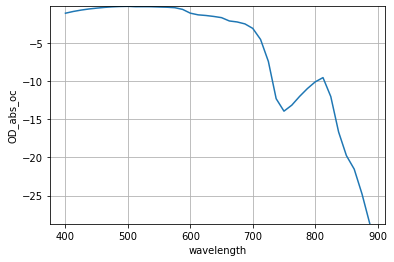

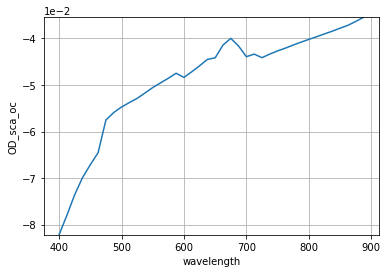

In [7]:
waterC1Sand5m.describe()
waterC1Sand5m['OD_abs_oc'].sub()[:,-1].plot()
figure()
waterC1Sand5m['OD_sca_oc'].sub()[:,-1].plot()

In [14]:
# Goal: to simulate an observation from a satellite sensor 
# for 1 thv and 1 azimuth
# with a straight coastline (limit ocean land at x=0, ocean for x <0)
# the sensor is looking to a water pixel located at a distance 'dist' from the coastline
# we simulate a coastline as being the zone near a big circle, whose radius is 1e6 km
# centred on a point located far from the sensor (-1e6 km from the origin )
# The interior of the circle is the ocean

# Ocean surface
surf1 = RoughSurface(WAVE_SHADOW=True, WIND=3.)
surf2 = RoughSurface(WAVE_SHADOW=True, WIND=15.)

# Land environment
D1       = 1.0e6 #(km)
D2       = 4
# The Environement object creates a disk of ocean surface with radius ENV_SIZE
# centred on X0,Y0 , surrounded by lambertian reflector of albedo ALB
# env1 : oceanic straight coastline simulation
env1     = Environment(ENV=1, 
                      ENV_SIZE= D1 ,       # radius of the circle with ocean surface condition
                      X0= -D1,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=ALB[1] # Lambertian grey albedo of the land zone (forest)
                     )
# env2 : small water body simulation
env2     = Environment(ENV=1, 
                      ENV_SIZE= D2 ,       # radius of the circle with ocean surface condition
                      X0= -D2,             # X coordinate of the center of the circle
                      Y0= 0,
                      ALB=ALB[1] # Lambertian grey albedo of the land zone (forest)
                     )

# Distance to coast/shore
dist1 = 1
dist2 = 10
dist3 = .5

#Observer at TOA
HTOA   = 120.
VZA    = 30.
VAA    = 90.
SZA    = 60.
SAA    = 0.
dist   = 1 # distance to the coast(km)
DeltaH = HTOA   * np.tan(np.radians(VZA))
DeltaX = DeltaH * np.cos(np.radians(180-VAA))
DeltaY = DeltaH * np.sin(np.radians(180-VAA))
sensor_TOA = Sensor(
    POSX = -dist + DeltaX,      # Sensor coordinates (in km) (default:origin(0.,0.,0.))
    POSY = DeltaY,
    POSZ = HTOA,
    THDEG= 180-VZA, # Sensor 'Emitting' zenith angle, from 0: Zenith to 180.: Nadir (default:0.)
    PHDEG= VAA,     # Sensor 'Emitting' azimuth angle (default:0.)
    LOC  = 'ATMOS', # location of sensor (default: (SURF0P, just above surface)
    FOV  = 0.,      # Sensor FOV (default 0.)
    TYPE = 0        # Sensor type :Radiance (0), Planar flux (1), Spherical Flux (2), (default 0)
    )

# Observer at BOA (0+)
sensor_BOA = Sensor(POSX = -dist, THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='ATMOS')
# Observer at Top Of Ocean (0-)
sensor_TOO = Sensor(POSX = -dist, THDEG=180-VZA, PHDEG=VAA, TYPE=0, LOC='OCEAN')
# Sun
sun = Sensor(POSZ=HTOA, THDEG=180-SZA, PHDEG=SAA, TYPE=0, LOC='ATMOS')

# Atmosphere
# to be computed at eh same wavlegnth grid as water IOP's
atm = AtmAFGL('afglt', comp=[AeroOPAC('continental_average', 0.2, 550)], pfwav=wav_vsf).calc(wav)

## Smartg modes
- Backward is necessary for adjacency because of Horizontal invariance breaking
-- Observer is at the sensor (TOA, 0+, 0-, etc...), output is at the TOA for solar geometries!
- Backward is possible if no adjacency
-- Observer is at the sensor (TOA, 0+, 0-, etc...), output is at the TOA for solar geometries!
- Forward is possible if no adjacency
-- Solar geometries as inputs
-- Local estimates for observations and at observation altitudes (TOA,0+,0-,etc..) using OUTPUT_LAYERS=3

In [15]:
# Backward Local Estimate -> Solar geometries
leb = {'th_deg':np.array([SZA]), 'phi_deg':np.array([SAA])}
# Forward Local Estimate -> observation geometries
lef = {'th_deg':np.array([VZA]), 'phi_deg':np.array([VAA])}

alis = True
alis_options = {'nlow':-1}
SMBa = Smartg(device=0, back=True, alt_pp=True, alis=alis)
SMB  = Smartg(device=0, back=True, alt_pp=True)

SMFa = Smartg(device=0, back=False, alt_pp=True, alis=alis)
SMF  = Smartg(device=0, back=False, alt_pp=True)

## Case 1

In [16]:
%%time
# case1 water w/ alis and adjacency : Backward
mBc1env  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, env=env, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis and no adjacency : Backward
mBc1  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, env=None, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case1 water w/ alis and no adjacency : Forward
mFc1  = SMFa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, stdev=True,
                   sensor=sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 1.8 s, sys: 1.26 s, total: 3.06 s
Wall time: 3.06 s


<ErrorbarContainer object of 3 artists>

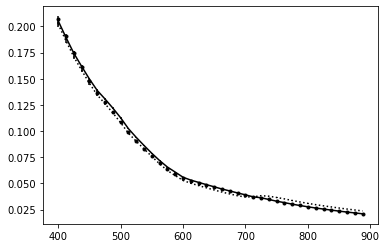

In [17]:
lut1 = mBc1 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBc1 ['I_stdev_up (TOA)'].sub()[:,0,0]

lut2 = mBc1env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBc1env ['I_stdev_up (TOA)'].sub()[:,0,0]

lut3 = mFc1 ['I_up (TOA)'].sub()[:,0,0]
err3 = mFc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='k-') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='k:') # Backward adjacency
errorbar(wav, lut3.data, yerr=err3.data, fmt='k.') # Forward  no adjacency

### Other Levels
- Forward no adjacency

#### 0+ : including sun and sky glint

(0.0, 0.025)

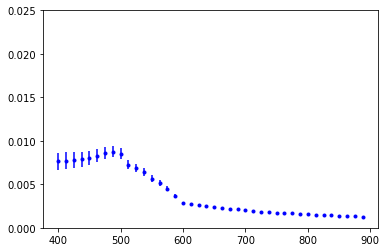

In [18]:
## BOA (forward sim so no adjacency)
lut2 = mFc1 ['I_up (0+)'].sub()[:,0,0]
err2 = mFc1 ['I_stdev_up (0+)'].sub()[:,0,0]
errorbar(wav, lut2.data, yerr=err2.data, fmt='b.') # Forward  no adjacency
ylim(0,0.025)

#### 0- 

(0.0, 0.025)

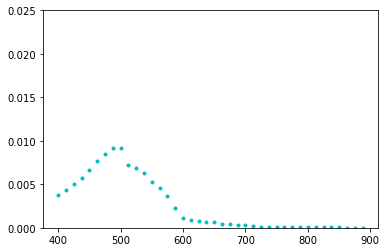

In [19]:
lut2 = mFc1 ['I_up (0-)'].sub()[:,0,0]
err2 = mFc1 ['I_stdev_up (0-)'].sub()[:,0,0]
errorbar(wav, lut2.data, yerr=err2.data, fmt='c.') # Forward  no adjacency
ylim(0,0.025)

### Other Levels
- Backward

#### 0+

In [20]:
%%time
# case1 water w/ alis and adjacency
mBOAc1env  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, env=env, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis and no adjacency
mBOAc1  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 1.07 s, sys: 785 ms, total: 1.86 s
Wall time: 1.85 s


(0.0, 0.025)

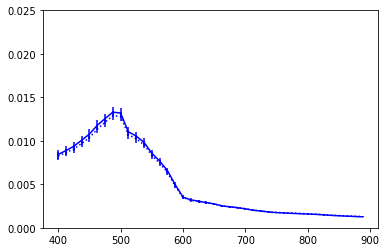

In [21]:
lut1 = mBOAc1 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOAc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOAc1env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOAc1env ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='b-') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='b:') # Backward adjacency
ylim(0,0.025)

#### 0-

In [22]:
%%time
# case1 water w/ alis and adjacency
mBOOc1env  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, env=env, stdev=True,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis and no adjacency
mBOOc1  = SMBa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 1.09 s, sys: 732 ms, total: 1.82 s
Wall time: 1.82 s


(0.0, 0.025)

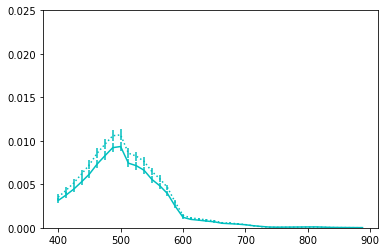

In [23]:
lut1 = mBOOc1 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOOc1 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOOc1env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOOc1env ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='c-') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='c:') # Backward adjacency
ylim(0,0.025)

## Case 2

In [24]:
%%time
# case2 water w/ alis and adjacency : Backward
mBc2env  = SMBa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e5, env=env, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case2 water w/ alis and no adjacency : Backward
mBc2  = SMBa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e5, env=None, stdev=True,
                   sensor=sensor_TOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case2 water w/ alis and no adjacency : Forward
mFc2  = SMFa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e5, env=None, stdev=True, 
                   sensor=sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

Box(children=(FloatProgress(value=0.0, max=100000.0), Label(value='')), layout=Layout(align_items='center', di…

Box(children=(FloatProgress(value=0.0, max=100000.0), Label(value='')), layout=Layout(align_items='center', di…

Box(children=(FloatProgress(value=0.0, max=100000.0), Label(value='')), layout=Layout(align_items='center', di…

CPU times: user 3.73 s, sys: 2.76 s, total: 6.48 s
Wall time: 6.49 s


<ErrorbarContainer object of 3 artists>

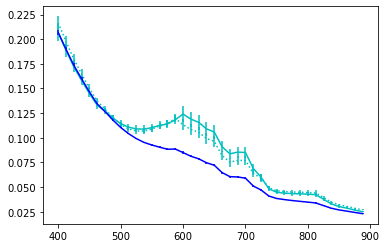

In [35]:
lut1 = mBc2 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBc2 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBc2env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBc2env ['I_stdev_up (TOA)'].sub()[:,0,0]
lut3 = mFc2 ['I_up (TOA)'].sub()[:,0,0]
err3 = mFc2 ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='c-') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='c:') # Backward adjacency
errorbar(wav, lut3.data, yerr=err3.data, fmt='b-') # Forward  no adjacency

In [31]:
%%time
## CASE 2 backward sims

# case2 water w/ alis and adjacency
mBOAc2env  = SMBa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e6, env=env, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

# case2 water w/ alis and no adjacency
mBOAc2  = SMBa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e6, stdev=True,
                   sensor=sensor_BOA, NF=1e3, alis_options=alis_options, le=leb, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

## CASE 2 forward sim

# case2 water w/ alis and no adjacency : Forward
mFc2  = SMFa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e6, stdev=True,
                   sensor=sun, NF=1e3, alis_options=alis_options, le=lef, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=3)

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

Box(children=(FloatProgress(value=0.0, max=1000000.0), Label(value='')), layout=Layout(align_items='center', d…

CPU times: user 20.1 s, sys: 16 s, total: 36.1 s
Wall time: 36.2 s


(0.0, 0.08)

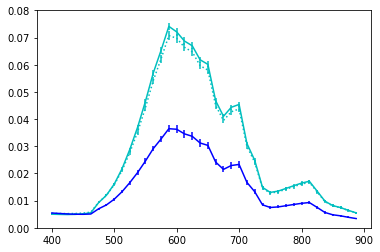

In [33]:
lut1 = mBOAc2 ['I_up (TOA)'].sub()[:,0,0]
err1 = mBOAc2 ['I_stdev_up (TOA)'].sub()[:,0,0]
lut2 = mBOAc2env ['I_up (TOA)'].sub()[:,0,0]
err2 = mBOAc2env ['I_stdev_up (TOA)'].sub()[:,0,0]
#------------
errorbar(wav, lut1.data, yerr=err1.data, fmt='c-') # Backward no adjacency
errorbar(wav, lut2.data, yerr=err2.data, fmt='c:') # Backward adjacency
ylim(0,0.08)

## BOA (forward sim so no adjacency)
lut2 = mFc2 ['I_up (0+)'].sub()[:,0,0]
err2 = mFc2 ['I_stdev_up (0+)'].sub()[:,0,0]
errorbar(wav, lut2.data, yerr=err2.data, fmt='b-') # Forward  no adjacency
ylim(0,0.08)

In [52]:
%%time
# case1 water w/ alis and adjacency
mBOAc1env  = SMa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e5, env=env,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case1 water w/ alis and no adjacency
mBOAc1  = SMa.run(wl=wav, water=water1, atm=atm, surf=surf, NBPHOTONS=1e5,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=100000.0), Label(value='')), layout=Layout(align_items='center', di…

Box(children=(FloatProgress(value=0.0, max=100000.0), Label(value='')), layout=Layout(align_items='center', di…

CPU times: user 1.76 s, sys: 1.67 s, total: 3.42 s
Wall time: 3 s


In [54]:
# case2 water w/ alis and adjacency
mBOAc2env  = SMa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e4, env=env,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)


# case2 water w/ alis and no adjacency
mBOAc2  = SMa.run(wl=wav, water=water2, atm=atm, surf=surf, NBPHOTONS=1e4,
                   sensor=sensor_TOO, NF=1e3, alis_options=alis_options, le=le, RR=1, WEIGHTRR=.1, OUTPUT_LAYERS=0)

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

Box(children=(FloatProgress(value=0.0, max=10000.0), Label(value='')), layout=Layout(align_items='center', dis…

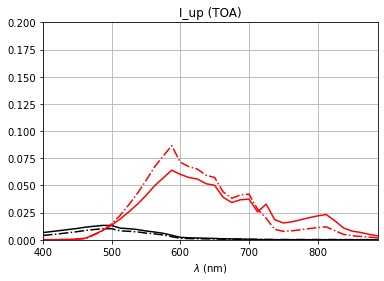

In [55]:
## compare case1 and case2 no ENV at BOA

lut1 = mBOAc1 ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut2 = mBOAc2['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut3 = mBOAc1env ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut4 = mBOAc2env['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})

f = figure()
spectrum(lut1, vmin=0, vmax=.2, sub=111,  fig=f, color='k', percent=False, fmt='-') # case1
spectrum(lut2, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-') # case2
spectrum(lut3, vmin=0, vmax=.2, sub=None,  fig=f, color='k', percent=False, fmt='-.') # case1 adjacency
spectrum(lut4, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-.') # case2 adjacency

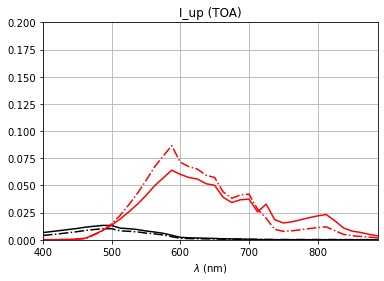

In [56]:
## compare case1 and case2 no ENV at BOA

lut1 = mBOAc1 ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut2 = mBOAc2['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut3 = mBOAc1env ['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})
lut4 = mBOAc2env['I_up (TOA)'].sub({'Zenith angles':Idx(30), 'Azimuth angles':Idx(90)})

f = figure()
spectrum(lut1, vmin=0, vmax=.2, sub=111,  fig=f, color='k', percent=False, fmt='-') # case1
spectrum(lut2, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-') # case2
spectrum(lut3, vmin=0, vmax=.2, sub=None,  fig=f, color='k', percent=False, fmt='-.') # case1 adjacency
spectrum(lut4, vmin=0, vmax=.2, sub=None, fig=f, color='r', percent=False, fmt='-.') # case2 adjacency

## Comments on BOA reflectance

- Shouldn't water leaving reflectance not be affected by adjacency, as the contribution should solely be due to upwelling radiance?? 
- Similar abnormal spike around 580nm in the adjacency LUT for case2. 
- It also seems the red/NIR region is too high compared to the blue. Especially the case1 spectra should have much higher values in the blue than NIR. Is water taken into account well enough?